In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow.keras as krs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/refmodel/understand_cnn/saved_model.pb
/kaggle/input/refmodel/understand_cnn/keras_metadata.pb
/kaggle/input/refmodel/understand_cnn/variables/variables.index
/kaggle/input/refmodel/understand_cnn/variables/variables.data-00000-of-00001


In [2]:
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
nptest = test.to_numpy()
nptest = nptest.astype('float')
nptest /= 255.0
nptest = nptest.reshape(-1, 28, 28, 1)

#plt.imshow(nptest[1,:,:,0])

In [3]:
ref_model=krs.models.load_model('/kaggle/input/refmodel/understand_cnn')
ref_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                        

1/1 [==============================] - 0s 403ms/step


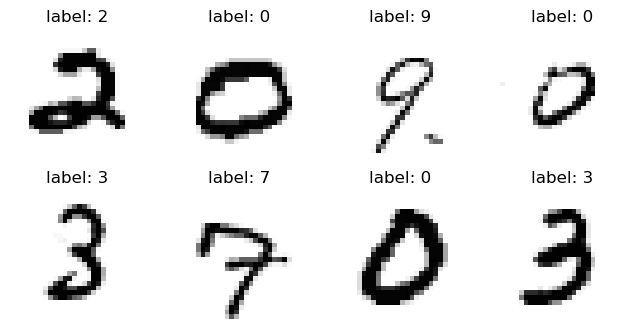

In [4]:
test_pred_cat=ref_model.predict(nptest[0:8,:,:,0])
test_pred_label=test_pred_cat.argmax(axis=1)

fig = plt.figure(figsize = (8, 8))
for k in range(0,8):
    ax = plt.subplot(4, 4, k+1)
    plt.imshow(nptest[k,:,:,0], cmap='Greys')
    plt.title("label: {}".format(test_pred_label[k]))
    ax.axis("off")

In [5]:
classifier = krs.models.Model(inputs=ref_model.get_layer('dropout_2').input, outputs=ref_model.output)
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1, 128)]       0         
                                                                 
 dropout_2 (Dropout)         (None, 1, 1, 128)         0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 35,594
Trainable params: 35,594
Non-trainable p

In [6]:
def output_at_index_0(input_tensor, max_idx):
    target = tf.Variable(tf.zeros(10))
    target=target[max_idx].assign(1)
    label = classifier(input_tensor)
    loss = loss = tf.keras.losses.mean_squared_error(target, label)
    return loss

activation_r = tf.Variable(tf.zeros((1, 1, 1, 128)))
optimizer = tf.optimizers.Adam(learning_rate=0.1)
for i in range(100):
    with tf.GradientTape() as tape:
        output = output_at_index_0(activation_r, 3)
    gradients = tape.gradient(output, activation_r)
    optimizer.apply_gradients([(gradients, activation_r)])

activation_g = tf.Variable(tf.zeros((1, 1, 1, 128)))
optimizer = tf.optimizers.Adam(learning_rate=0.1)
for i in range(100):
    with tf.GradientTape() as tape:
        output = output_at_index_0(activation_g, 5)
    gradients = tape.gradient(output, activation_g)
    optimizer.apply_gradients([(gradients, activation_g)])

activation_b = tf.Variable(tf.zeros((1, 1, 1, 128)))
optimizer = tf.optimizers.Adam(learning_rate=0.1)
for i in range(100):
    with tf.GradientTape() as tape:
        output = output_at_index_0(activation_b, 1)
    gradients = tape.gradient(output, activation_b)
    optimizer.apply_gradients([(gradients, activation_b)])
    
    
#print(input_var.value)


(4, 32, 3)
-1.4033216
1.4246267


(-0.5, 31.5, 3.5, -0.5)

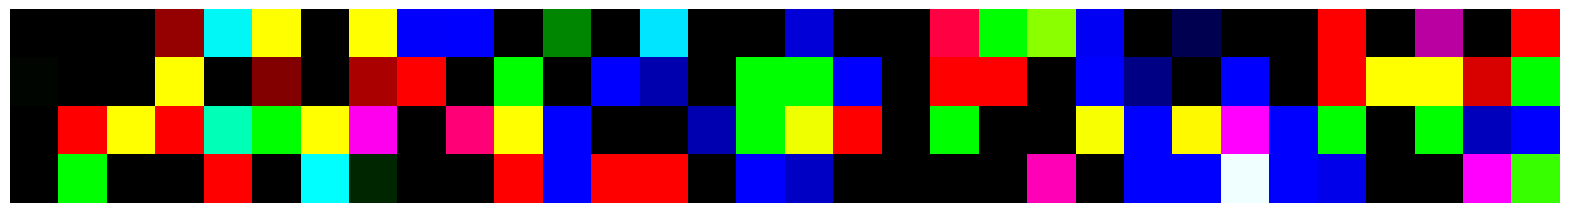

In [7]:
#img=np.stack([activation_r.numpy().reshape(), activation_g.numpy()[0,0,0,:], activation_b.numpy()[0,0,0,:]], axis=1)
img=np.stack([activation_r.numpy()[0,0,0,:].reshape(4, 32),
              activation_g.numpy()[0,0,0,:].reshape(4, 32),
              activation_b.numpy()[0,0,0,:].reshape(4, 32)], axis=2)
print(img.shape)
img_min=np.amin(img)
img_max=np.amax(img)
print(img_min)
print(img_max)

plt.figure(figsize=(20, 60))
plt.imshow(img, vmin=img_min, vmax=img_max)
plt.axis("off")

In [8]:
x_ver=activation_r.numpy()
x_ver=x_ver.reshape(1,1,1,128)
print(x_ver.shape)
y_ver = classifier.predict(x_ver)
print(y_ver)

(1, 1, 1, 128)
1/1 [==============================] - 0s 65ms/step
[[4.2387205e-06 2.9287571e-06 2.6298856e-05 9.9937940e-01 1.0079852e-06
  3.2113295e-04 1.4320403e-06 8.2764782e-06 2.1807227e-04 3.7183872e-05]]


In [9]:
def input_from_index(input_tensor, max_idx):
    target = tf.Variable(tf.zeros(10))
    target=target[max_idx].assign(1)
    label = ref_model(input_tensor)
    loss = loss = tf.keras.losses.mean_squared_error(target, label)
    return loss

activation_pict = tf.Variable(tf.zeros((1, 28, 28, 1)))
optimizer = tf.optimizers.Adam(learning_rate=0.1)
for i in range(100):
    with tf.GradientTape() as tape:
        output = input_from_index(activation_pict, 1)
    gradients = tape.gradient(output, activation_pict)
    optimizer.apply_gradients([(gradients, activation_pict)])


(-0.5, 27.5, 27.5, -0.5)

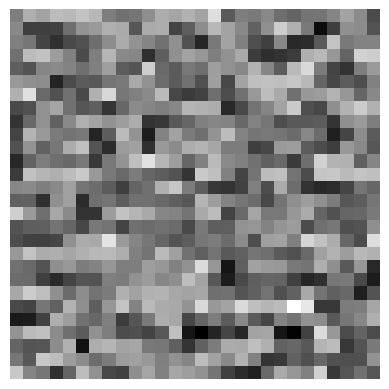

In [10]:
#plt.figure(figsize=(10, 10))
plt.imshow(activation_pict[0,:,:,0], cmap='gray')
plt.axis("off")